# Creative Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [1]:
# Check if we have a GPU available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

2025-03-09 12:07:24.116793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-09 12:07:24.130366: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-09 12:07:24.135207: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-09 12:07:24.231996: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Default GPU Device: /device:GPU:0


I0000 00:00:1741536446.740048 1017792 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741536446.926086 1017792 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741536446.929255 1017792 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741536447.071198 1017792 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [2]:
import requests
import os

def download_file(book_name):
    base_url = "https://raw.githubusercontent.com/UofT-DSI/deep_learning/refs/heads/main/02_activities/assignments/downloaded_books/"
    file_url = base_url + book_name
    local_filename = book_name

    response = requests.get(file_url)
    if response.status_code == 200:
        with open(local_filename, 'w', encoding='utf-8') as f:
            f.write(response.text)
        print(f"Downloaded {book_name} successfully!")
        return local_filename
    else:
        raise ValueError("Failed to download the file. Please check the filename and try again.")

def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

# Prompt user to select a book
title_options = {
    "1": "charles_dickens.txt",
    "2": "mark_twain.txt",
    "3": "shakespeare.txt"
}

print("Choose a book to download:")
print("1: Charles Dickens")
print("2: Mark Twain")
print("3: William Shakespeare")

choice = None
while choice not in title_options:
    choice = input("Enter the number corresponding to your choice (1, 2, or 3): ").strip()
    if choice not in title_options:
        print("Invalid choice. Please enter 1, 2, or 3.")

selected_book = title_options[choice]
file_path = download_file(selected_book)

# Load chosen dataset
fraction = 0.1  # Adjust fraction if running out of memory
text = load_dataset(file_path, fraction=fraction)

print("Dataset loaded successfully!")

Choose a book to download:
1: Charles Dickens
2: Mark Twain
3: William Shakespeare
Downloaded charles_dickens.txt successfully!
Dataset loaded successfully!


# 1. Data Preparation (10 Marks)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration (3 Marks)

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [3]:
# Solution
print(text[:1000])
print('The dataset contains {} characters.'.format(len(text)))
unique_chars = sorted(set(text))
print('The dataset contains {} unique characters.'.format(len(unique_chars)))

The Project Gutenberg eBook of A Tale of Two Cities, by Charles Dickens

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.

Title: A Tale of Two Cities
       A Story of the French Revolution

Author: Charles Dickens

Release Date: January, 1994 [eBook #98]
[Most recently updated: December 20, 2020]

Language: English

Character set encoding: UTF-8

Produced by: Judith Boss and David Widger

*** START OF THE PROJECT GUTENBERG EBOOK A TALE OF TWO CITIES ***




A TALE OF TWO CITIES

A STORY OF THE FRENCH REVOLUTION

By Charles Dickens


CONTENTS


     Book the First--Recalled to Life

     CHAPTER I 

## 1.2 Text Pre-Processing (4 Marks)

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [12]:
# Solution
from tensorflow.keras.preprocessing.text import Tokenizer

VOCAB_SIZE = 2000
OOV_TOKEN = "<unknown>"

# Convert the entire text to lowercase
text = text.lower()

# Tokenize the text
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts([text])


If everything worked, the following line should show you the first 10 words in the vocabulary:

In [13]:
print(list(tokenizer.word_index.items())[:10])

[('<unknown>', 1), ('the', 2), ('and', 3), ('of', 4), ('to', 5), ('a', 6), ('in', 7), ('’', 8), ('his', 9), ('he', 10)]


## 1.3 Sequence Generation (3 Marks)

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [42]:
# Solution
SEQ_LENGTH = 10


# Convert the text to a list of sequences of numbers
sequences = tokenizer.texts_to_sequences([text])[0]

# Generate the training sequences
X = []
y = []

i=0
while i+SEQ_LENGTH+1 < len(sequences):
    x_seq = sequences[i:i+SEQ_LENGTH]
    i = i+SEQ_LENGTH
    y_seq = sequences[i]
    i += 1
    X.append(x_seq)
    y.append(y_seq)


Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [43]:
print(f'Sequence: {X[0]}\nTarget: {y[0]}')
print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')

Sequence: [2, 240, 220, 1359, 4, 6, 1448, 4, 88, 1]
Target: 32
Translated back to words: ['the', 'project', 'gutenberg', 'ebook', 'of', 'a', 'tale', 'of', 'two', '<unknown>'] -> by


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [152]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

# One last thing: let's drop any examples where the target is the OOV token - we don't want our model to predict that (boring!)
mask = y != tokenizer.word_index[OOV_TOKEN]
X = X[mask]
y = y[mask]

# One-hot encode the target token
y = to_categorical(y, num_classes=VOCAB_SIZE)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

IndexError: boolean index did not match indexed array along dimension 1; dimension is 10 but corresponding boolean dimension is 2000

# 2. Model Development (10 Marks)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture (4 Marks)

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [160]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, InputLayer

model = Sequential([
    InputLayer(shape=X_train[0].shape),
    Embedding(VOCAB_SIZE, 64),
    Conv1D(128, 5, activation='relu'),
    LSTM(128, return_sequences=True),
    LSTM(256),
    Dense(VOCAB_SIZE, activation='softmax')
])

model.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_30 (Embedding)        │ (None, 10, 64)         │       128,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 6, 128)         │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ (None, 6, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 2000)           │       514,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,208,912 (4.61 MB)

 Trainable params: 1,208,912 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

## 2.2 Model Compilation (3 Marks)

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

_your explanation here_

_Choosing categorical focal cross entropy as the loss function because we have a multi class classification problem with class imbalances._

_Choosing Adam as the optimizer because it generally works well even with bad initialization_

In [161]:
# Solution
from tensorflow.keras.optimizers import Adam

model.compile(
    loss='categorical_focal_crossentropy',
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)

## 2.3 Model Training (3 Marks)

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [162]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=128
)

Epoch 1/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0536 - loss: 1.5668 - val_accuracy: 0.0681 - val_loss: 1.4529
Epoch 2/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0726 - loss: 1.4086 - val_accuracy: 0.0902 - val_loss: 1.4094
Epoch 3/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0933 - loss: 1.3507 - val_accuracy: 0.1013 - val_loss: 1.3941
Epoch 4/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1089 - loss: 1.3052 - val_accuracy: 0.0992 - val_loss: 1.3806
Epoch 5/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1134 - loss: 1.2760 - val_accuracy: 0.1061 - val_loss: 1.3761


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

Text(0.5, 1.0, 'Loss')

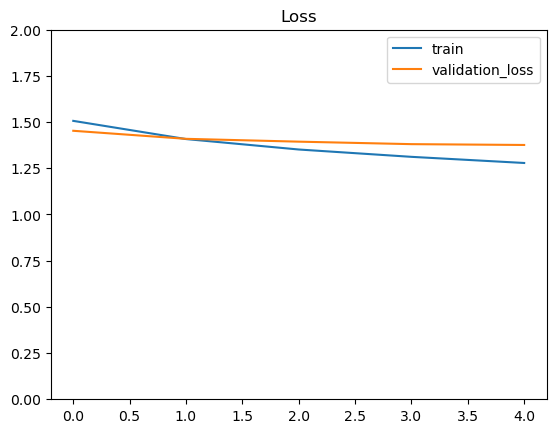

In [163]:
# Solution
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss')

# 3. Text Generation (10 Marks)

## Task Overview

In this task, you will write a function called `generate_text` that uses a trained RNN model to generate new text based on a given seed phrase.

Your function **must** follow a structured approach to text generation, where the model predicts one word at a time, adds it to the sequence, and repeats this process until a desired length is reached.

## Function Requirements

You need to implement a function with the following signature:

```python
def generate_text(model, tokenizer, seed_text, max_sequence_len, n_words=100):
```

### **Parameters**
- `model`: The trained RNN model that will generate text.
- `tokenizer`: The tokenizer used to convert words to numerical sequences.
- `seed_text`: The initial text that will be used to start generating words.
- `max_sequence_len`: The maximum length of input sequences (same as used in training).
- `n_words` (optional, default=100): The number of words to generate.

### **Expected Output**
- A single **string** containing the generated text.

---

## **Step-by-Step Instructions**

### **1. Tokenize the seed text**
Use the tokenizer to convert `seed_text` into a sequence of numbers:

```python
encoded = tokenizer.texts_to_sequences([seed_text])[0]
```

### **2. Pad the sequence to match training input length**
Ensure that the sequence is the correct length by padding it **at the beginning**:

```python
from tensorflow.keras.preprocessing.sequence import pad_sequences
encoded = pad_sequences([encoded], maxlen=max_sequence_len, truncating='pre')
```

### **3. Predict the next word**
Pass the padded sequence to the model to predict the next word.

- The model will output a probability distribution over the vocabulary.
- Use `np.random.choice` or `np.argmax` to select the most likely word.

```python
yhat = model.predict(encoded, verbose=0)
predicted_word_index = np.argmax(yhat)  # Select the word with the highest probability
```

### **4. Convert the predicted word index to a word**
Find the corresponding word in the tokenizer’s vocabulary:

```python
out_word = tokenizer.index_word[predicted_word_index]
```

### **5. Append the new word to the generated text**
- Add the predicted word to `seed_text`.
- Repeat the process to generate multiple words.

```python
seed_text += " " + out_word
```

### **6. Repeat Steps 3-5 until `n_words` have been generated**

- Each time, remove the oldest word from the input sequence to keep its length constant.
- Continue generating words one at a time until reaching `n_words`.

---

## **Important Notes**
- If the generated text doesn’t make much sense, don’t worry! The quality will improve as the model is trained better.
- This is a **challenging** task! If you get stuck, ask for help.
- The `generate_text` function should return the **full generated text as a single string**.

### **Example Usage**
After implementing `generate_text`, you should be able to call it like this:

```python
generated_text = generate_text(model, tokenizer, "Once upon a time", max_sequence_len=20, n_words=50)
print(generated_text)
```

This should output a string of 50 words generated by the model, starting with `"Once upon a time"`.

In [164]:
# Solution
from tensorflow.keras.preprocessing.sequence import pad_sequences


def generate_text(model, tokenizer, seed_text, max_sequence_len, n_words=100):
    words = seed_text.split(" ")
    current_word_count = len(words)

    while current_word_count < n_words:
        encoded = tokenizer.texts_to_sequences(words)[0]
        encoded = pad_sequences([encoded], maxlen=max_sequence_len, truncating='pre')
        
        yhat = model.predict(encoded, verbose=0)
        predicted_word_index = np.random.choice([i for i in range(1, VOCAB_SIZE+1)], p=yhat[0])
        out_word = tokenizer.index_word[predicted_word_index]
        seed_text += " " + out_word
        words.append(out_word)
        words.pop(0)
        current_word_count += 1

    return seed_text

In [165]:
generate_text(model, tokenizer, 'Once upon a time', SEQ_LENGTH)

"Once upon a time pickwick stopped least them mr a in seemed direction dowler was as ' pickwick as and are better and and 1 ‘well man be pair be and may of ” man worth and his feel when short period said were care seat in pretty of to and was and ” man a found you said last in no and interposed not our and said be through bed and mr and ” man town dragged you pickwick that and don’t very with over ” sawyer on her year ” while something your you ‘well of but you"

In [166]:
# Test the text generation function
generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)

'hamlet to along said and answered and clothes magnus a never this your without be a surprised had and is serjeant it mr fogg what for ’ this always into back she are and doors at and three them pickwick every of and in through and on and in not mr exclaimed and his speed all had resumed and in be whole around few come for stopped then and little mother a trouble i everything street fell glancing his might houses up sir of as is and boy were day so hands that and might too pickwick you their drinking'

# 4. Model Refinement (5 Marks)

## **Understanding Your Model's Performance**

At this stage, you might have noticed that the text generated by your model doesn’t make much sense yet. **This is completely expected!**

There are a few reasons why:
1. **RNNs have limitations** – While they can generate sequences, they struggle with long-range dependencies in text.
2. **Character-by-character generation is outdated** – Modern models like ChatGPT don’t generate text one letter at a time. Instead, they use **tokens**, which represent larger chunks of words, making their outputs much more coherent.
3. **Training time and data size** – Our model has been trained on a relatively small dataset for a short period of time, which means it hasn’t learned enough patterns to generate meaningful text.

Even though we don’t expect ChatGPT-level performance, this exercise is about **experimentation, not perfection**. Your goal here is to try **at least one** way to refine your model and observe how it affects the output.

---

## **Refining Your Model**
There are many ways to try improving your model. Here are some ideas:

✅ **Use pre-trained embeddings**  
   Instead of learning word representations from scratch, you can use pre-trained word embeddings. This allows your model to start with a better understanding of word relationships.

✅ **Modify the model architecture**  
   - Experiment with **more layers** or different numbers of units per layer.  
   - Try adding **dropout layers** to prevent overfitting.  
   - Consider using **bidirectional RNNs**, which process text in both forward and backward directions.  

✅ **Train for longer**  
   - Try increasing the number of **epochs** (but be mindful of overfitting).  
   - Experiment with different **batch sizes** to see if they affect training stability.  

Again, **perfection is NOT the goal here** – we just want to see that you experimented with improving your model! 🚀

In [167]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

--2025-03-09 19:26:21--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2025-03-09 19:29:01 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [171]:
# Load the pre-trained embeddings
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.


In [172]:
# Create an embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [173]:
embedding_layer = Embedding(
    VOCAB_SIZE, 100, weights=[embedding_matrix], trainable=False
)

In [261]:
# Solution
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, Bidirectional, InputLayer

model = Sequential([
    InputLayer(shape=X_train[0].shape),
    embedding_layer,
    Conv1D(128, 5, activation='relu'),
    Bidirectional(LSTM(256, return_sequences=True)),
    Bidirectional(LSTM(512)),
    Dense(1024, activation='relu'),
    Dropout(0.4),
    Dense(2048, activation='relu'),
    Dropout(0.5),
    Dense(VOCAB_SIZE, activation='softmax')
])

model.summary()

model.compile(
    loss='categorical_focal_crossentropy',
    optimizer=Adam(learning_rate=3e-4),
    metrics=['accuracy']
)

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_32 (Embedding)        │ (None, 10, 100)        │       200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_40 (Conv1D)              │ (None, 6, 128)         │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_101               │ (None, 6, 512)         │       788,480 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_102               │ (None, 1024)           │     4,198,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 2048)           │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 2000)           │     4,098,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,497,808 (47.68 MB)

 Trainable params: 12,297,808 (46.91 MB)

 Non-trainable params: 200,000 (781.25 KB)

In [262]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)

Epoch 1/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.0620 - loss: 1.5547 - val_accuracy: 0.0681 - val_loss: 1.4534
Epoch 2/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.0660 - loss: 1.4411 - val_accuracy: 0.0878 - val_loss: 1.4203
Epoch 3/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.0903 - loss: 1.3746 - val_accuracy: 0.1056 - val_loss: 1.3720
Epoch 4/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1082 - loss: 1.3168 - val_accuracy: 0.1080 - val_loss: 1.3567
Epoch 5/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1140 - loss: 1.2790 - val_accuracy: 0.1126 - val_loss: 1.3491
Epoch 6/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1204 - loss: 1.2483 - val_accuracy: 0.1154 - val_loss: 1.3466
Epoch 7/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1293 - loss: 1.2159 - val_accuracy: 0.1151 - val_loss: 1.3514
Epoch 8/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1366 - loss: 1.1837 - val_accu

Text(0.5, 1.0, 'Loss')

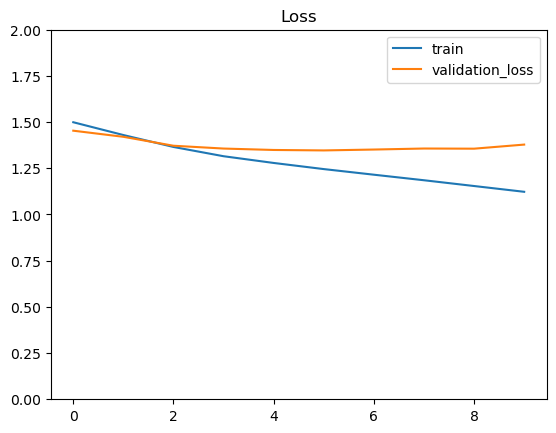

In [263]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss')

In [264]:
# Test the text generation function
generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)

"hamlet rather former shall this difficulty in minutes a take that your come tone of whom will far returned back heard winkle good it’s show hand was mrs but my drew he sam look cold when which while little shall is make short quickly fire a word set back ’ above manner of down any fat till jinks thing him pale north very pross his say and fingers want be snodgrass ' table sam 1 goblin at she sudden darnay him daughter beside of were brothers your do brought did this samuel too days ' more went appearance i young"